In [30]:
import sys
sys.path.append('..')

from scripts.GenrationGI0 import rGI0, partitioned_gi0_image
from scripts.autoencoders import InMemoryImageDataset, generate_multiple_images, Autoencoder

import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

---
### Empiezo graficando algunos ejemplos de imagenes

In [31]:
g, gi, gI0 = rGI0(n=100*100, p_alpha=-1.5, p_gamma=1, p_Looks=1)

In [32]:
g = g.reshape(100, 100)
gi = gi.reshape(100, 100)
gI0 = gI0.reshape(100, 100)

Text(0.5, 1.0, 'Ruido speckle ~ Gamma')

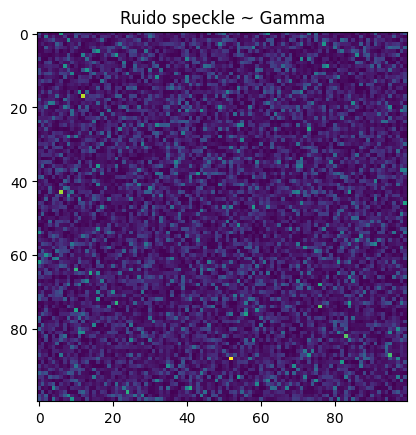

In [33]:
plt.imshow(g)
plt.title('Ruido speckle ~ Gamma')

Text(0.5, 1.0, 'Backscatter ~ Gamma inversa')

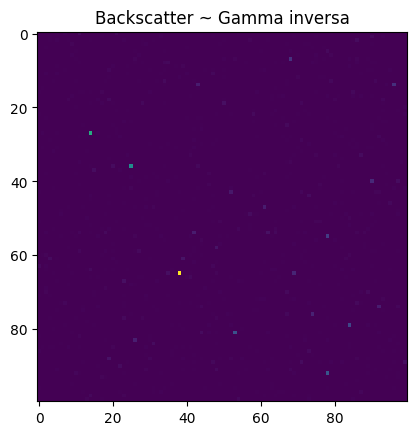

In [34]:
plt.imshow(gi)
plt.title('Backscatter ~ Gamma inversa')

Text(0.5, 1.0, 'Imagen + ruido speckle ~ GI0')

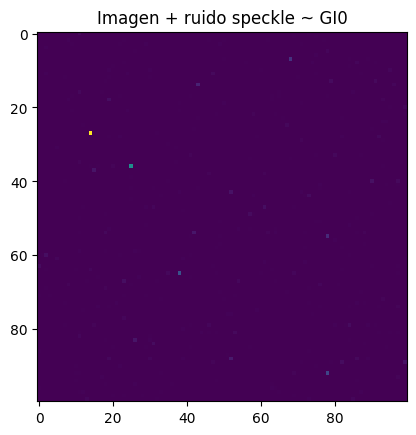

In [35]:
plt.imshow(gI0)
plt.title('Imagen + ruido speckle ~ GI0')

In [36]:
imagen_g, imagen_gi, imagen_gI0 = partitioned_gi0_image(
    p_alphas=[-1.5,-5,-1.7,-10],
    p_gammas=[1,1,1,1],
    p_looks=[1,1,1,1]
)

Text(0.5, 1.0, 'Imagen particionada - Ruido speckle ~ Gamma')

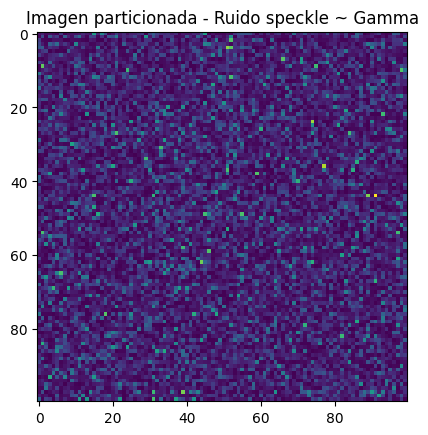

In [37]:
plt.imshow(imagen_g)
plt.title('Imagen particionada - Ruido speckle ~ Gamma')

Text(0.5, 1.0, 'Imagen particionada - Backscatter ~ Gamma inversa')

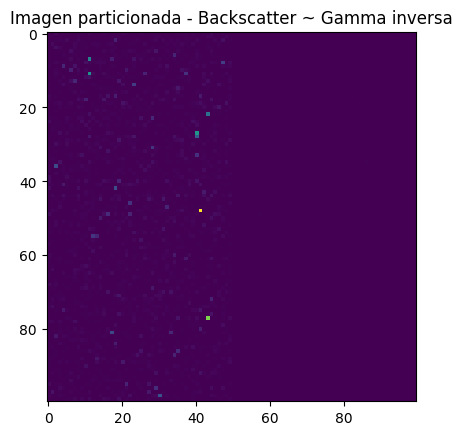

In [38]:
plt.imshow(imagen_gi)
plt.title('Imagen particionada - Backscatter ~ Gamma inversa')

Text(0.5, 1.0, 'Imagen particionada - Imagen + ruido speckle ~ GI0')

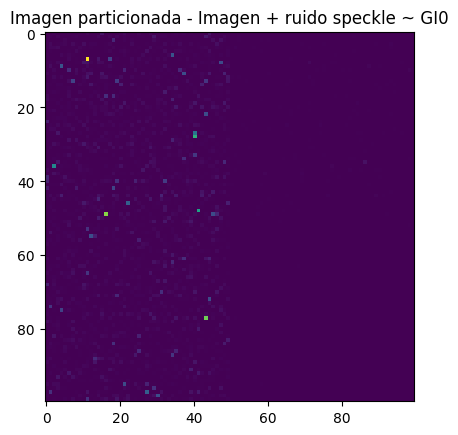

In [39]:
plt.imshow(imagen_gI0)
plt.title('Imagen particionada - Imagen + ruido speckle ~ GI0')

---
### Genero un dataset para entrenar

In [40]:
n = 1000
train_g, train_gi, train_gI0 = generate_multiple_images(n, partitioned_gi0_image)

In [41]:
batch_size = 32

In [42]:
normalize_to_01 = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_to_01
])

dataset_train = InMemoryImageDataset(train_gI0, train_gi, transform=transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [43]:
entrada_red, salida_red = dataset_train[21]

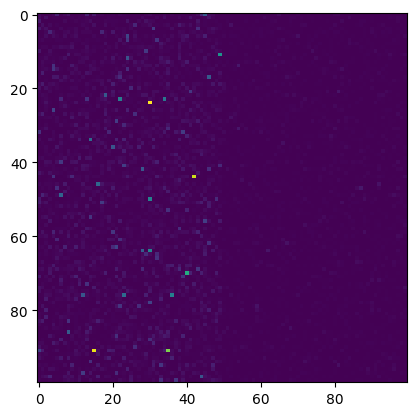

In [44]:
plt.imshow(entrada_red[0,:,:])

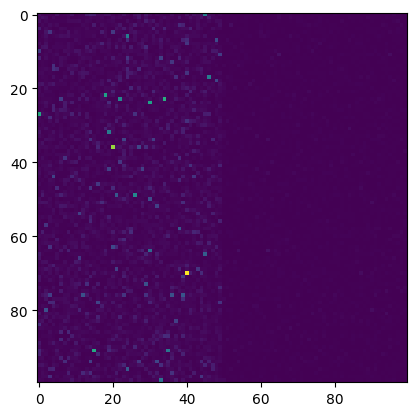

In [45]:
plt.imshow(salida_red[0,:,:])

---
### Entreno

In [46]:
encoding_dim = 32
learning_rate = 1e-3
num_epochs = 10

In [47]:
autoencoder = Autoencoder(encoding_dim)
criterion = nn.BCELoss() # Utilizamos Binary Cross Entropy Loss como loss function ya que las imágenes están normalizadas en el rango [0, 1]
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate) # El optimizador es responsable de ajustar los pesos del modelo con el fin de minimizar la función de pérdida.
                                                                   # Adam es un algoritmo de optimización popular y eficiente que adapta la tasa de aprendizaje de forma dinámica para cada parámetro del modelo.
                                                                   # La tasa de aprendizaje determina qué tan rápido se ajustan los pesos del modelo durante el entrenamiento.


In [48]:
for epoch in range(num_epochs):
    for data in train_loader:
        entrada, salida = data
        entrada = entrada.view(entrada.size(0), -1).float()
        salida = salida.view(salida.size(0), -1).float()

        # Forward pass
        outputs = autoencoder(entrada) # Se pasa a las imágenes por el autoencoder, en una pasada forward.
        loss = criterion(outputs, salida) # Se calcula la diferencia entre el output y las imágenes sin ruido, según la función de pérdida definida.

        # Backward pass y optimización
        optimizer.zero_grad() # Se restablecen los gradientes acumulados en todos los parámetros del modelo.
                              # Esto es necesario antes de realizar el backward pass, ya que PyTorch acumula los gradientes en cada llamada a loss.backward().
        loss.backward() # Se realiza el backward pass para calcular los gradientes de los parámetros del autoencoder utilizando la función de pérdida.
        optimizer.step() # Finalmente se realiza la optimización de los parámetros del modelo mediante la llamada a optimizer.step(), que actualiza los parámetros en función de los gradientes calculados.

    # Imprimir la pérdida del autoencoder en cada época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.5157
Epoch [2/10], Loss: 0.2878
Epoch [3/10], Loss: 0.1415
Epoch [4/10], Loss: 0.1648
Epoch [5/10], Loss: 0.0558
Epoch [6/10], Loss: 0.0573
Epoch [7/10], Loss: 0.0973
Epoch [8/10], Loss: 0.0856
Epoch [9/10], Loss: 0.1583
Epoch [10/10], Loss: 0.0757


---
### Evalúo

In [49]:
# Primero genero el dataset para evaluar

n = 1000
test_g, test_gi, test_gI0 = generate_multiple_images(n, partitioned_gi0_image)

batch_size = 32

dataset_test = InMemoryImageDataset(test_gI0, test_gi, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [50]:
total_loss = 0
with torch.no_grad(): # Esto es para asegurarse de que no se realicen cálculos de gradientes durante la evaluación del autoencoder.
                      # Al entrar en este bloque, se desactiva el cálculo y almacenamiento automático de gradientes para reducir el uso de memoria y acelerar la evaluación.
    for data in test_loader:
        entrada, salida = data # _ se utiliza para descartar las etiquetas, ya que no son necesarias para la evaluación.
        entrada = entrada.view(entrada.size(0), -1).float() # Se modifica la forma de las imágenes para que coincida con el formato esperado por el autoencoder.
                                                         # En este caso, las imágenes se aplanan en un tensor unidimensional. images.size(0) se utiliza para obtener el tamaño del lote.
        salida = salida.view(salida.size(0), -1).float()

        # Forward pass
        outputs = autoencoder(entrada) # Se realiza el forward pass del autoencoder con las imágenes de prueba.
                                      # El autoencoder genera las imágenes reconstruidas utilizando el método forward() que definimos previamente en la clase Autoencoder.
        loss = criterion(outputs, salida) # Se calcula la pérdida entre las imágenes reconstruidas y las imágenes originales utilizando la función de pérdida (criterion).
                                          # Esto proporciona una medida de cuánto difieren las imágenes reconstruidas de las originales.
        total_loss += loss.item() # La pérdida obtenida en cada iteración se suma a la variable total_loss utilizando loss.item(), que devuelve el valor escalar de la pérdida.
                                  # Al final de la iteración, total_loss contendrá la suma acumulada de las pérdidas de todas las muestras del conjunto de datos de prueba.

average_loss = total_loss / len(test_loader) # Se calcula la pérdida promedio dividiendo la suma acumulada de las pérdidas (total_loss) entre el número de lotes en el conjunto de datos de prueba (len(test_loader)).
                                             # Esto proporciona una medida promedio de la discrepancia entre las imágenes originales y las imágenes reconstruidas por el autoencoder en el conjunto de datos de prueba.
print(f"Average Test Loss: {average_loss:.4f}")

Average Test Loss: 0.0993
